
# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with keras.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)
- This data goes by various name, including the "Adult" dataset and 1996 census data

In [5]:
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn import metrics as mt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn import metrics as mt
from tensorflow import keras
import missingno as mn

In [37]:
df_train_orig =  pd.read_csv('../hr_train.csv')
df_test_orig = pd.read_csv('../hr_test.csv')
df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18359 entries, 0 to 18358
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18359 non-null  int64  
 1   city                    18359 non-null  object 
 2   city_development_index  18359 non-null  float64
 3   gender                  14261 non-null  object 
 4   relevent_experience     18359 non-null  object 
 5   enrolled_university     18017 non-null  object 
 6   education_level         17902 non-null  object 
 7   major_discipline        15521 non-null  object 
 8   experience              18300 non-null  object 
 9   company_size            13580 non-null  object 
 10  company_type            13320 non-null  object 
 11  last_new_job            17992 non-null  object 
 12  training_hours          18359 non-null  int64  
 13  target                  18359 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

In [40]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354,25366,city_103,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,5,<10,Pvt Ltd,1,71,0
18355,25545,city_160,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,15,50-99,Pvt Ltd,1,160,0
18356,11514,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,11,50-99,Pvt Ltd,3,18,0
18357,1689,city_75,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,3,41,0


#### TODO Table of columns

In [43]:
import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1,12036,city_28,0.939,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,94
3,5032,city_104,0.924,Male,No relevent experience,no_enrollment,Phd,STEM,>20,50-99,Pvt Ltd,2,76
4,17599,city_77,0.830,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,<10,Pvt Ltd,2,65
5,19314,city_160,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,100-500,Pvt Ltd,2,33
6,12365,city_21,0.624,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,48


<AxesSubplot:>

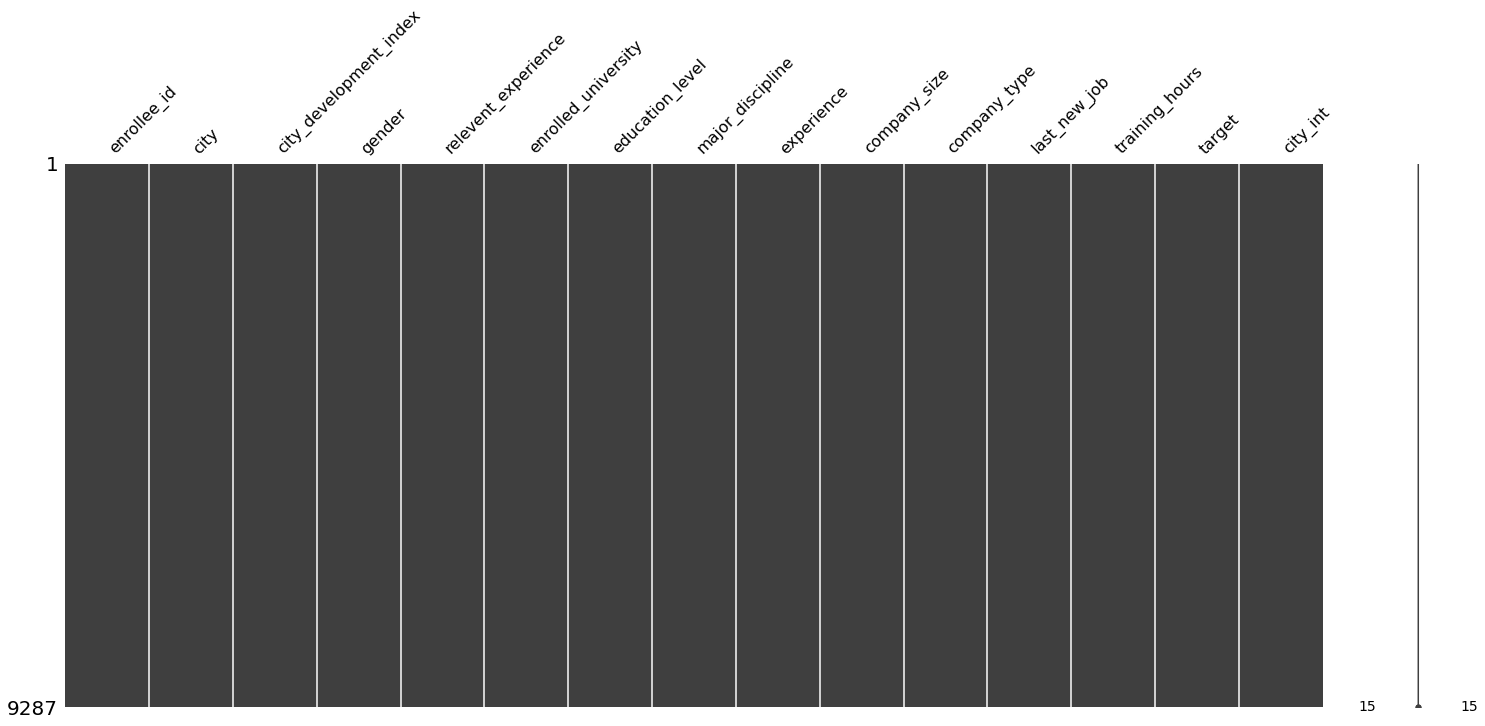

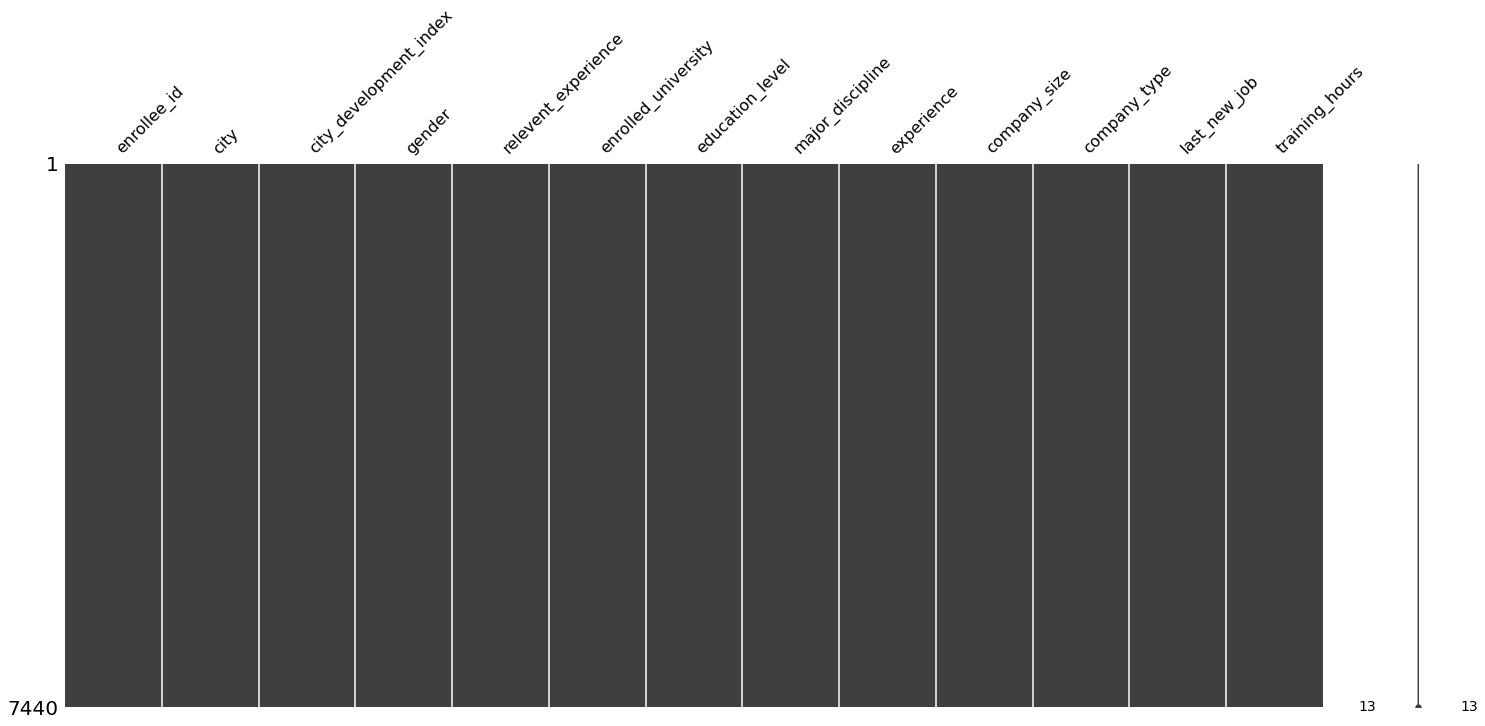

In [12]:

mn.matrix(df_train)

mn.matrix(df_test)

## Processing
For preprocessing, we are going to fix a few issues in the dataset. 

- This first includes the use of "50K." instead of "50K" in the test set. 
- Next, we will encode the categorical features as integers (eventually we will deal with these integers like a one-hot encoding)
- Finally, we will make certain all the continuous data is scaled properly with zero mean and unit standard deviaiton

In [16]:
#replace comapny size
df_train['company_size'].replace(to_replace=['10/49'], value=['10-49'], inplace=True) #fix the records with 10/49 instead of 10-49
ranges = ['<10', '10-49', '50-99', '100-500',  '500-999', '1000-4999', '5000-9999', '10000+']
values = [10,   29.5,     74.5,    300,        749.5,     2999.5,      7499.5,      10000]
df_train['company_size'].replace(to_replace=ranges, value=values, inplace=True)
df_train['company_size'].unique()

df_test['company_size'].replace(to_replace=['10/49'], value=['10-49'], inplace=True) #fix the records with 10/49 instead of 10-49
ranges = ['<10', '10-49', '50-99', '100-500',  '500-999', '1000-4999', '5000-9999', '10000+']
values = [10,   29.5,     74.5,    300,        749.5,     2999.5,      7499.5,      10000]
df_test['company_size'].replace(to_replace=ranges, value=values, inplace=True)
df_test['company_size'].unique()

array([   74.5,    10. ,   300. , 10000. ,    29.5,  7499.5,  2999.5,
         749.5])

In [25]:
only_one = []
for city in df_test['city'].unique():
    if len(df_train[df_train.city == city]) == 0:
        only_one.append(city)
for city in df_train['city'].unique():
    if len(df_test[df_test.city == city]) == 0:
        only_one.append(city)

for droper in only_one:
    df_train = df_train[df_train.city != droper]
    df_test = df_test[df_test.city != droper]

____________________________________________


In [31]:
df_train.replace(to_replace=['>20', '<1'], value=[20, 0], inplace=True)
df_train.replace(to_replace=['>4', 'never'], value=[5, 0], inplace=True)
df_test.replace(to_replace=['>20', '<1'], value=[20, 0], inplace=True)
df_test.replace(to_replace=['>4', 'never'], value=[5, 0], inplace=True)

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## replace strings
#if df_test.traget.dtype=='object':
#    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],value=['<=50K','>50K'],inplace=True)
#    print(df_test.income.value_counts())
#
# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['city','gender','relevent_experience',
                       'enrolled_university','education_level','major_discipline',
                       'company_type']

# train all encoders (special case the target 'income')
for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()

    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])

# scale the numeric, continuous variables
numeric_headers = ["experience", "city_development_index", "last_new_job",
                   "training_hours"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,city_int,gender_int,relevent_experience_int,enrolled_university_int,education_level_int,major_discipline_int,company_type_int
1,12036,city_28,0.772355,Male,No relevent experience,no_enrollment,Graduate,STEM,1.314581,74.5,Pvt Ltd,-0.833868,0.477174,60,1,1,2,0,5,5
3,5032,city_104,0.622553,Male,No relevent experience,no_enrollment,Phd,STEM,1.314581,74.5,Pvt Ltd,-0.237807,0.179383,6,1,1,2,2,5,5
4,17599,city_77,-0.316206,Male,Has relevent experience,no_enrollment,Graduate,STEM,-0.931593,10.0,Pvt Ltd,-0.237807,-0.002601,92,1,0,2,0,5,5
5,19314,city_160,0.582606,Male,Has relevent experience,no_enrollment,Graduate,STEM,-0.771152,300.0,Pvt Ltd,-0.237807,-0.532006,43,1,0,2,0,5,5
6,12365,city_21,-2.373487,Male,Has relevent experience,no_enrollment,Graduate,STEM,-1.412916,10000.0,Pvt Ltd,-0.833868,-0.283847,54,1,0,2,0,5,5


In [36]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['target'].values.astype(np.int)
y_test = df_test['target'].values.astype(np.int)

print(feature_columns)

KeyError: 'target'

In [16]:
from sklearn import metrics as mt
from tensorflow import keras

keras.__version__

'2.4.0'

In [17]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model

In [18]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].to_numpy()
X_test = df_test[feature_columns].to_numpy()

Much better!! Looks like the use of Embedding layers helped. Lets add some more of the features, useing both the categorical and the integer features.

## Multi-Modal Networks: Combine Branches, Sparse and Dense
The keras functional API allows us to setup different branches of inputs. When we call the `fit` function, we can tell keras the input to each branch using a simple list (you can also use a dictionary to be more explicit).

- Lets create two matrics: 
 - one with the categorical data, `X_train_cat`
 - and another with the numeric data, `X_train_num`
 
Now, we can feed both of these into the model as a list and concatenate their results. 


___


## Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. We will perform this step using `sklearn` 

Let's start simple with 
- branches of crossed categorical features as input 
- one branch for each crossed column

In [19]:
# possible crossing options:
#   'workclass','education','marital_status',
#   'occupation','relationship','race',
#   'sex','country'

cross_columns = [['sex','education','occupation'],
                 #['sex', 'marital_status'],
                 ['workclass','occupation'],
                 ['occupation','race']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    


___


## Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.

In [21]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)



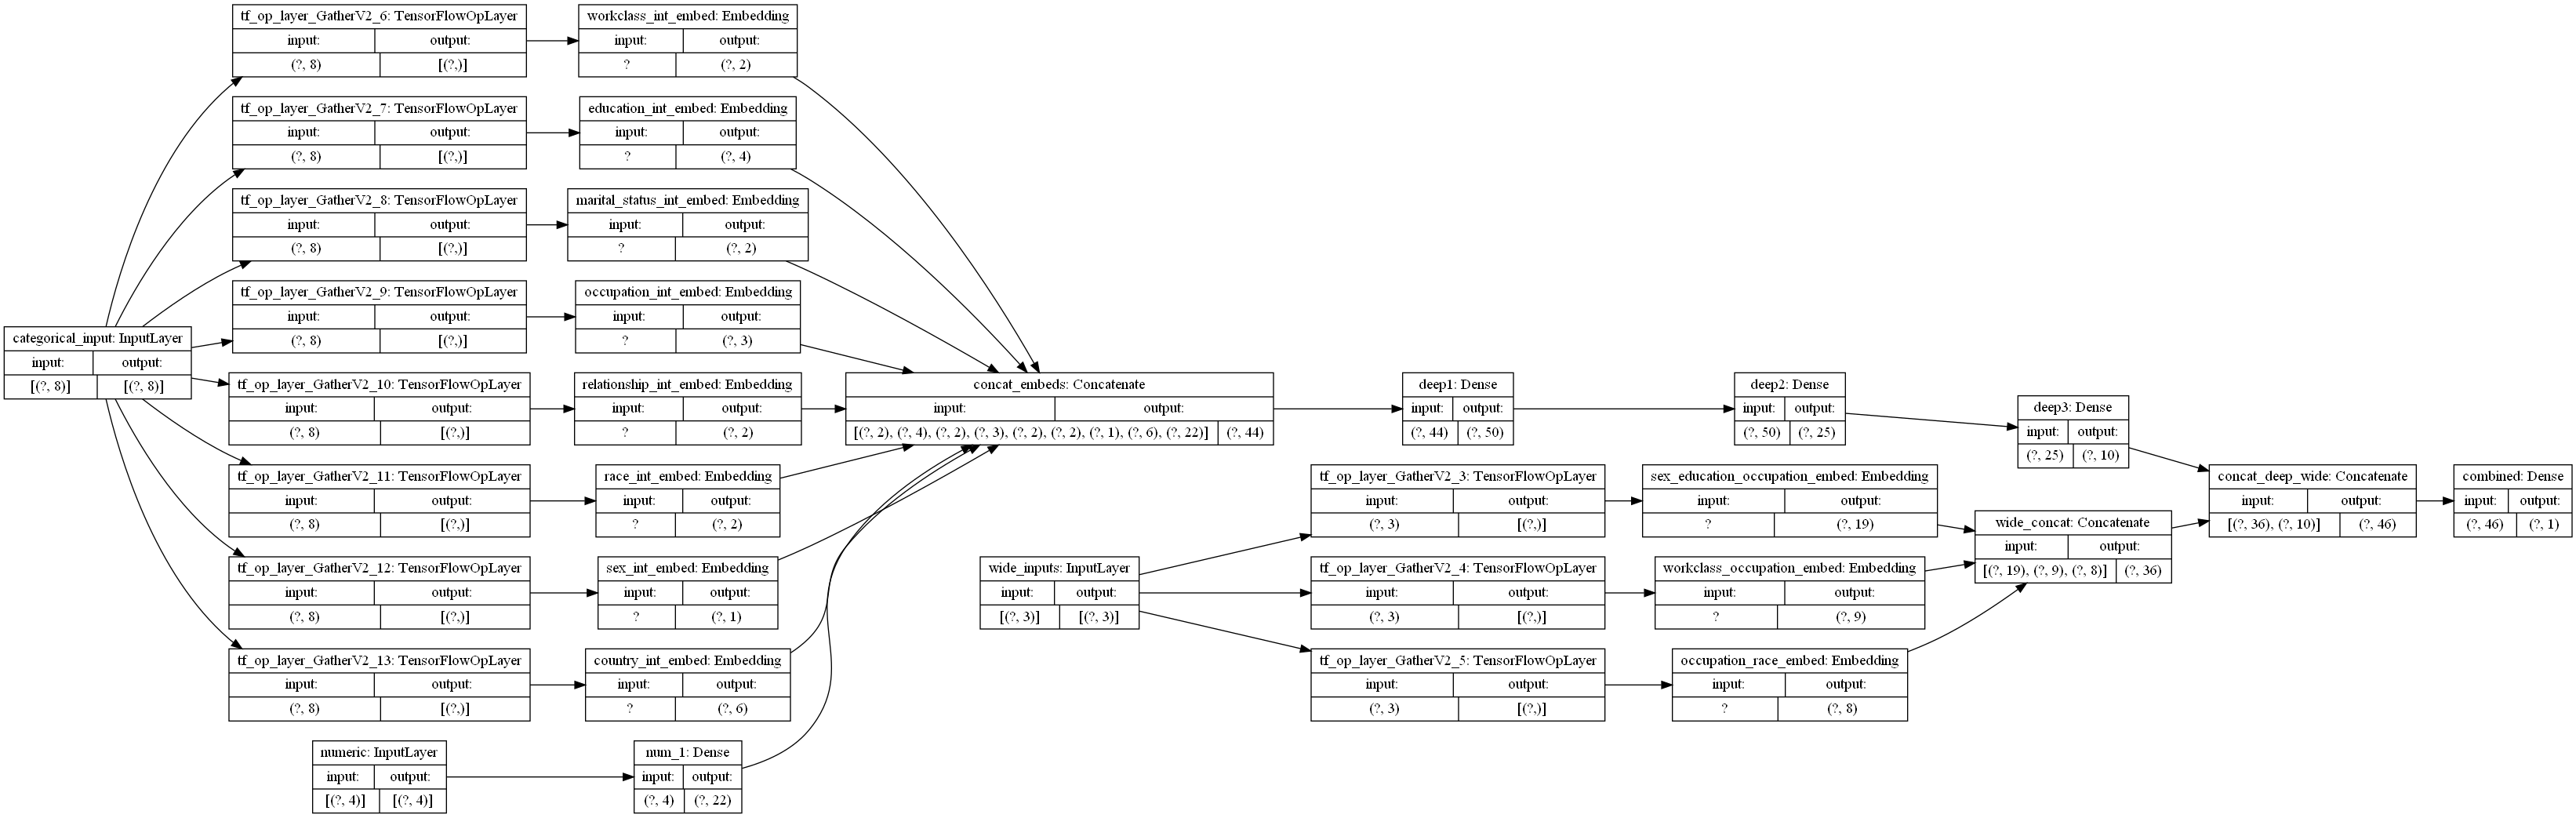

In [23]:
from tensorflow.keras.utils import plot_model

# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/50
943/943 [==============================] - 1s 1ms/step - loss: 0.2403 - accuracy: 0.7103 - val_loss: 0.2327 - val_accuracy: 0.7519
Epoch 2/50
943/943 [==============================] - 1s 945us/step - loss: 0.2266 - accuracy: 0.7503 - val_loss: 0.2206 - val_accuracy: 0.7544
Epoch 3/50
943/943 [==============================] - 1s 951us/step - loss: 0.2149 - accuracy: 0.7510 - val_loss: 0.2090 - val_accuracy: 0.7543
Epoch 4/50
943/943 [==============================] - 1s 946us/step - loss: 0.2035 - accuracy: 0.7511 - val_loss: 0.1979 - val_accuracy: 0.7543
Epoch 5/50
943/943 [==============================] - 1s 948us/step - loss: 0.1928 - accuracy: 0.7511 - val_loss: 0.1877 - val_accuracy: 0.7543
Epoch 6/50
943/943 [==============================] - 1s 952us/step - loss: 0.1836 - accuracy: 0.7511 - val_loss: 0.1794 - val_accuracy: 0.7543
Epoch 7/50
943/943 [==============================] - 1s 951us/step - loss: 0.1762 - accuracy: 0.7511 - val_loss: 0.1730 - val_accuracy: 0

In [ ]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)
model.summary()

In [ ]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

# Making Generalization Better
In what ways might we try to make the model found generalize more concretely?

**Self Test:** What is the best method to make the results better?  
- A. Add Dropout to deep network
- B. Add Dropout to wide network
- C. Perturb the Categorical Data during Training (augmentation)
- D. Add L2 regularization to different layer's weights